# 'Recommendation of similar articles from journal abstract analysis'  
# Modeling for recommendation creation
## 2019, Misty M. Giles
### https://github.com/OhThatMisty/astro_categories/

In [180]:
%matplotlib inline

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import spacy
import unicodedata

plt.style.use('fivethirtyeight')

In [181]:
def normalize(text):
    '''Convert to ascii, remove special characters associated with LaTeX when given a df column,
       only keep alpha chars'''
    normalized_text = []
    
    for t in text:
        t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()
        # This pair is necessary to separate some words because of the LaTeX/mathtext formatting 
        t = re.sub('mathrm|gtrsim|lesssim|odot|langle', ' ', t)
        t = re.sub('rangle|rm off|\\\\\S*|\$\S*\$|\set[\. ]+al[\. ]+', ' ', t) 
        # Collapse terms like x-ray that are disappearing
        t = re.sub(r'\bx-\b', 'x_', t)
        # Remove everthing but alpha, underscores
        t = re.sub('[^a-zA-Z_]+', ' ', remove_stopwords(t))
        # strip_short gets rid of the rest of the math leftovers
        normalized_text.append(strip_short(t, minsize=2))
    return normalized_text

# This function is to remove excess whitespace 
def remove(token):
    '''Provide feedback on whether a token is excess whitespace'''
    return token.is_space or token.is_digit

# This function ensures that all printouts use the same formula
def join_tokens(sent):
    '''Joins tokens in a sent without whatever is in remove(), adds pronoun back
       in instead of -PRON-'''
    return ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text.lower()
                     for token in sent if not remove(token)])

# This function prevents nested lists that kill the vectorizer
def join_sentences(doc):
    '''Joins sentences in a doc (includes join_tokens)'''
    return ' '.join([join_tokens(sent) for sent in doc.sents])

# Set up spacy to lemmatize the text
nlp = spacy.load('en', disable=['ner'])

###  Change the "docs_to_run" variable in this box to reflect testing/full run.

In [182]:
# Get the csv file created in the cleaning notebook
file = os.path.join('..', 'data', 'astro_intermediate.csv')
df = pd.read_csv(file, index_col=0)
# Shuffle the df so that all times available are represented in both test and train
df = df.sample(frac=1).reset_index(drop=True)

# Set variables for testing speed
docs_to_run = len(df)  # 1000 for testing, len(df) for real processing
train_docs = int(0.98 * docs_to_run)  # 98% training, 2% test
test_docs = docs_to_run - train_docs
print('Setting up to train on', train_docs, 'abstracts.')
print('Setting up test block of', test_docs, 'abstracts.')
print('Total', docs_to_run, 'abstracts in session.')

# Set up the sentences_file needed in later steps
sentences_file = os.path.join('..', 'data', 'astro_normalized_premodel.txt')

Setting up to train on 58772 abstracts.
Setting up test block of 1200 abstracts.
Total 59972 abstracts in session.


### For the next three boxes (4, 5, 6):  Box 4 will take quite awhile to run.  Box 5 writes the result of box 4 to a text file.  Box 6 will stream the text file back into the notebook or recreate the variable "text" that can be used in the rest of the notebook without any more changes.  Box 6 will need to be altered depending on your purpose. 

In [183]:
%%time

# This is the long box - 1h on quad-core, 8G RAM machine.  If you already have the sentences_file
# saved, you can ignore these two boxes and make any alterations you need to in the following box.

# Clean the file (remove punctuation, lowercase, lemmatize, remove 1-char objects --
# most are math/LaTeX formatting leftovers or possessives)
text = [join_sentences(doc) for doc in nlp.pipe(normalize(df.abstract[:docs_to_run]), batch_size=50)]

Wall time: 1h 3min 40s


In [184]:
# Ignore this box if using the sentences_file from GitHub.

# Create a filepath and write out the sentences, removing stopwords to save space on GitHub.
with open(sentences_file, 'w') as out_file:
     for sent in text:
            out_file.write(remove_stopwords(sent) + '\n')

In [185]:
# This is the box where you might need some edits if using the sentences_file.  If you are, 
# results might slightly vary.

# Code for printing out an article from the text file to test it.  Can be used to stream
# if you use the iterator method.

# Iterator method (uncomment all three lines):
#sentences = open(sentences_file, 'r')
#for i, line in enumerate(sentences):
#    if i == 10980: print(line)
        
# Recreate the variable "text" (uncomment 1st, 2nd, 4th):
#with open(sentences_file, 'r') as in_file:
#    text = list(in_file)
# Test that "text" recreated appropriately (printout should be a list with string: ['lots of words'])
#text[10980:10981]

In [186]:
print('Sample abstract to demonstrate cleaning (or verify good import):\n')
print(text[article_idx])

Sample abstract to demonstrate cleaning (or verify good import):

expression average redshift drift statistically homogeneous isotropic dust universe give expression take form expression redshift drift flrw model proof of principle study effect backreaction redshift drift measurement combine expression two region model study show backreaction lead positive redshift drift low redshift exemplify positive redshift drift low redshift require dark energy moreover study illustrate model dark energy component average redshift drift observationally indistinguishable standard model accord currently expect precision elt measurement appendix spherically symmetric solution einstein equation inhomogeneous dark energy matter study deviation average redshift drift effect local void


### Model: tfidf using sklearn

In [198]:
%%time

# Set up the model for vectorizing/calculating the similarity; words must appear 
# in at least 400 documents.   
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=0.01)

# Transform/fit the training and test data to the model
tfidf_matrix = tfidf.fit_transform(text[:train_docs]).todense()
article_matrix = tfidf.transform(text[train_docs:]).todense()

# Create a df of the model's values
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names())
article_df = pd.DataFrame(article_matrix, columns=tfidf.get_feature_names())

Wall time: 1min 44s


In [199]:
print('Training vocabulary:', len(tfidf.get_feature_names()))
print('Stopwords:', len(tfidf.stop_words_))

Training vocabulary: 1723
Stopwords: 7043791


In [189]:
# Remove the stopwords to free up some memory
delattr(tfidf, 'stop_words_')

In [216]:
tfidf.get_feature_names()

['ability',
 'able',
 'abridge',
 'absence',
 'absolute',
 'absorb',
 'absorption',
 'absorption line',
 'abundance',
 'accelerate',
 'acceleration',
 'accompany',
 'accord',
 'account',
 'accrete',
 'accreting',
 'accretion',
 'accretion disk',
 'accretion rate',
 'accuracy',
 'accurate',
 'accurately',
 'achieve',
 'acoustic',
 'acquire',
 'act',
 'action',
 'active',
 'active galactic',
 'active galactic nucleus',
 'active region',
 'activity',
 'adaptive',
 'add',
 'addition',
 'additional',
 'additionally',
 'address',
 'adopt',
 'advance',
 'advanced',
 'advantage',
 'affect',
 'age',
 'agn',
 'ago',
 'agree',
 'agreement',
 'aim',
 'algorithm',
 'align',
 'all',
 'allow',
 'alma',
 'alpha',
 'alternative',
 'amplitude',
 'analyse',
 'analysis',
 'analytic',
 'analytical',
 'analyze',
 'and',
 'and or',
 'angle',
 'angular',
 'angular momentum',
 'angular resolution',
 'anisotropic',
 'anisotropy',
 'annihilation',
 'anti',
 'aperture',
 'apparent',
 'appear',
 'application',
 'a

###  Now that the model has been prepared, it's time to choose a sample abstract from the test set.  This is a proof-of-concept method for a recommendation engine that suggests articles based on the abstract you're reading.  As it's proof-of-concept, the abstract will be randomly chosen for you from the test abstracts.  (Abstract and highest-rated related abstract shown at bottom of notebook.)

In [217]:
# Pick an article to function as the sample 
article_idx = np.random.randint(0, test_docs)

# Uncomment the line below if you want to see the cleaned data from the new sample
#text[article_idx+train_docs:article_idx+train_docs+1]

#### Finding recommendations from tfidf and cosine similarity, using the sample abstract above.

In [218]:
# Compute the document similarities with sklearn linear_kernel.  Per sklearn,
# linear_kernal is faster than cosine_similarity for tfidf.
document_similarity = linear_kernel(article_df.iloc[article_idx:article_idx+1], tfidf_df).flatten()

# Get the indices for the documents that have highest cosine similarity to the sample.
related_indices = document_similarity.argsort()[:-7:-1]
related_indices

array([24217, 44204, 50976, 20541, 20115, 17372], dtype=int64)

In [219]:
# Create a df with the attributes of the similar documents
related_abstracts = df[['abstract', 'title', 'terms']].iloc[related_indices]
related_abstracts['document_similarity'] = document_similarity[related_indices]

# Print out the most similar documents
related_abstracts

,abstract,title,terms,document_similarity
24217,Bekenstein's generalized second law (GSL) of t...,Bekenstein's generalized second law of thermod...,gr-qc|astro-ph.HE|hep-th,0.562790
44204,We study the growth and saturation of the supe...,Superradiant Instability and Backreaction of M...,gr-qc|astro-ph.HE|hep-ph,0.549717
50976,Quintessential dark energy with pressure $p$ a...,Kerr-Newman-AdS Black Hole In Quintessential D...,gr-qc|astro-ph.HE,0.543145
20541,We have studied photon motion around axially s...,Optical properties of black hole in the presen...,gr-qc|astro-ph.HE,0.537876
20115,One of the most remarkable predictions of the ...,Upper bound on the radii of black-hole photons...,gr-qc|astro-ph.HE|hep-th,0.529754
17372,"Recently, two of us have found a family of sin...",Testing conformal gravity with the supermassiv...,gr-qc|astro-ph.HE,0.527468


### How much does the first result ("recommended abstract" from now on) have in common with the sample?  This table (sorted by feature importance of the sample article) shows how many and which of the top features match up.

In [220]:
# Get the features of the sample abstract
sample_features = dict(article_df.iloc[article_idx])
sample_features = pd.DataFrame.from_dict(sample_features, orient='index').reset_index()
sample_features.columns = ['feature', 'sample_importance']
# Get the features for the recommended abstract
related_features = dict(tfidf_df.iloc[related_indices[0]])
related_features = pd.DataFrame.from_dict(related_features, orient='index').reset_index()
related_features.columns = ['feature', 'recommended_importance']
# Concat dfs
features_df = sample_features.merge(related_features, on='feature')
features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]

,feature,sample_importance,recommended_importance
153,black hole,0.352653,0.508943
152,black,0.349817,0.504849
722,hole,0.347665,0.501743
414,dimension,0.227033,0.000000
1589,thermal,0.226737,0.000000
961,mechanism,0.218100,0.000000
1509,state,0.208788,0.000000
1359,rotate,0.179309,0.000000
1616,transfer,0.177065,0.000000
496,energy,0.156987,0.000000


### But what features were most important for the recommended article?

In [221]:
related_features.sort_values(by='recommended_importance', ascending=False)[:5]

,feature,recommended_importance
153,black hole,0.508943
152,black,0.504849
722,hole,0.501743
725,horizon,0.173855
85,area,0.142242


##### Here are the full, unaltered abstracts from the sample and the first recommended article.

In [222]:
# Get the abstract for the sample article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('ABSTRACT TO MATCH: \n', df.url.iloc[(article_idx + train_docs)], '\n')
print(df.title.iloc[(article_idx + train_docs)], '\n')
print(df.abstract.iloc[(article_idx + train_docs)], '\n')
print(df.terms.iloc[(article_idx + train_docs)])

ABSTRACT TO MATCH: 
 http://arxiv.org/abs/1709.10090v2 

Blandford-Znajek process in vacuo and its holographic dual 

Blandford and Znajek discovered a process by which a spinning black hole can transfer rotational energy to a plasma, offering a mechanism for energy and jet emissions from quasars. Here we describe a version of this mechanism that operates with only vacuum electromagnetic fields outside the black hole. The setting, which is not astrophysically realistic, involves either a cylindrical black hole or one that lives in 2+1 spacetime dimensions, and the field is given in simple, closed form for a wide class of metrics. For asymptotically Anti-de Sitter black holes in 2+1 dimensions the holographic dual of this mechanism is the transfer of angular momentum and energy, via a resistive coupling, from a rotating thermal state containing an electric field to an external charge density rotating more slowly than the thermal state. In particular, the entropy increase of the thermal 

In [223]:
# Get the abstract for the recommended article
# Abstract is unaltered from download (more human-readable but includes formatting).
print('HIGHEST-RATED MATCH \n', df.url.iloc[related_indices[0]], '\n')
print(df.title[related_indices[0]], '\n')
print(df.abstract[related_indices[0]], '\n')
print(df.terms[related_indices[0]])

HIGHEST-RATED MATCH 
 http://arxiv.org/abs/1511.03665v1 

Bekenstein's generalized second law of thermodynamics: The role of the   hoop conjecture 

Bekenstein's generalized second law (GSL) of thermodynamics asserts that the sum of black-hole entropy, $S_{\text{BH}}=Ac^3/4\hbar G$ (here $A$ is the black-hole surface area), and the ordinary entropy of matter and radiation fields in the black-hole exterior region never decreases. We here re-analyze an intriguing gedanken experiment which was designed by Bekenstein to challenge the GSL. In this historical gedanken experiment an entropy-bearing box is lowered into a charged Reissner-Nordstr\"om black hole. For the GSL to work, the resulting increase in the black-hole surface area (entropy) must compensate for the loss of the box's entropy. We show that if the box can be lowered adiabatically all the way down to the black-hole horizon, as previously assumed in the literature, then for near-extremal black holes the resulting increase in bla

### Now plots.

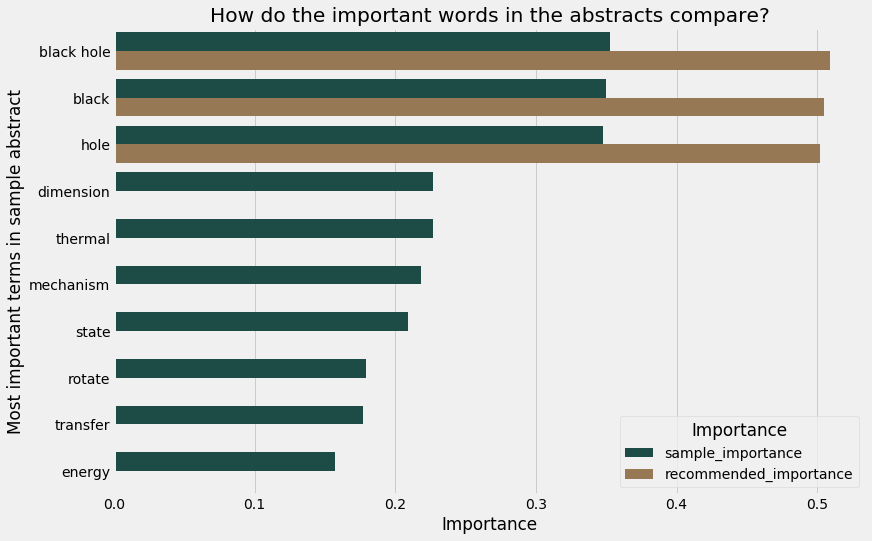

In [224]:
data = features_df.loc[features_df.sample_importance > 0].sort_values(by='sample_importance', ascending=False)[:10]
tidy = data.melt(id_vars='feature').rename(columns=str.lower)
tidy.columns = ['feature', 'Importance', 'value']
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x='value', y='feature', hue='Importance', data=tidy, palette=sns.color_palette("cubehelix", 3))
_ = plt.xlabel('Importance')
_ = plt.ylabel('Most important terms in sample abstract')
_ = plt.title('How do the important words in the abstracts compare?')